In [173]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

%matplotlib inline

SAMPLE_NUMBER = 213

from sklearn.linear_model import LinearRegression # linear regression
from sklearn.model_selection import train_test_split # split dataset into train & testing
from sklearn.metrics import mean_squared_error # calculate error

from sklearn.model_selection import train_test_split # split dataset into train & testing
from sklearn.metrics import max_error, mean_absolute_error # calculate error

import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from sklearn.linear_model import LinearRegression # linear regression

In [768]:
def read_filename(filename):

	# read table
	df = pd.read_csv(filename, sep='\t', decimal='.', header=None)

	# EG, FILENAME='PL_PC_records/PL and PC record-535-b-2.txt' --> ID_STRING='535-b-2.txt'
	id_string = filename.split('/')[2]
	cc = id_string.split('_') # split into parts with - inbetween

	print (cc)

	wavelength = cc[0] # wavelength
	location = cc[3] # background (b) or nv-center (nv)
	voltage = cc[2]

	# file has rows for columns, thus transpose
	df = df.transpose()

	# assign column meaning
	df['Laser Power (V)'] = df[0] # the header became the index after transposition
	df['PL (counts/s)'] = df[1]
	df['PC (pA)'] = df[2]

	# make the index a simple counter
	df = df.reset_index()

	# keep columns of interest
	df = df[['Laser Power (V)', 'PL (counts/s)', 'PC (pA)']]

	# assign identifiers to dataframe
	df['Wavelength'] = int(wavelength)
	df['Location'] = location
	df['Voltage'] = voltage

	df['Laser Power (V)'] = df['Laser Power (V)'].astype(float)
	df['PL (counts/s)'] = df['PL (counts/s)'].astype(float)
	df['PC (pA)'] =  df['PC (pA)'].astype(float)

	return df, wavelength, location, voltage

def read_experiment(fg, bg, plot=True):
	nv_df_0V, _ , _ , _ = read_filename(fg)
	nv_df_0V_BG, _ , _ , _ = read_filename(bg)

	# showcase Laser Power x PL
	if plot:
		fig, (ax1,ax2) = plt.subplots(1,2, figsize=(7,2.5))  # 1 row, 2 columns
		nv_df_0V.plot.scatter(x='Laser Power (V)', y='PL (counts/s)', ax=ax1, title=f"NV-Center {SAMPLE_NUMBER}  - Voltage to PhotoLuminesence")
		nv_df_0V_BG.plot.scatter(x='Laser Power (V)', y='PL (counts/s)', ax=ax2, title=f"Background {SAMPLE_NUMBER}  - Voltage to PhotoLuminesence")

	# plt.plot(X_test, y_pred,color='k')

	return nv_df_0V, nv_df_0V_BG

def read_experiment_w_exp_volt(wavelength, experiment_n, volt, background_picks, plot=False):
	
	background_n = background_picks[wavelength][volt]

	filename_fg = f'./SAT_CURVE/{wavelength}_NV_{volt}_fg_{experiment_n}.txt'
	filename_bg = f'./SAT_CURVE/{wavelength}_NV_{volt}_bg_{background_n}.txt'

	df_fg, df_bg = read_experiment(filename_fg, filename_bg, plot)

	df = fit_background(df_fg, df_bg, plot, wavelength)

	df['wavelength'] = wavelength
	df['experiment #'] = experiment_n
	df['sample'] = SAMPLE_NUMBER

	return df #, df_fg, df_bg

def fit_background(df_nv_fg, df_nv_bg, plot=True, wavelength=540):

	df_nv_bg = df_nv_bg.dropna()
	
	df_nv_bg = df_nv_bg.loc[df_nv_bg['Laser Power (V)'] < cutoff_voltage[int(wavelength)], :]

	# select first and last few items from background to make a better fit
	# df_nv_bg = pd.concat([df_nv_bg.head(5), df_nv_bg.tail(5)]).reset_index(drop=True)
	
	# fit background PL(V) function, should be linear
	X = df_nv_bg['Laser Power (V)'].to_numpy()
	y = df_nv_bg['PL (counts/s)'].to_numpy()

	# reshape data - [a,b,c,d] -> [[a], [b], [c], [d]] (because we have 1 feature for X)
	X = X.reshape(-1, 1)

	# fit regression
	reg = LinearRegression().fit(X, y)

	# predict on unseen values (X_test)
	y_pred = reg.predict(X)

	# plot input values, and fit
	if plot:
		fig, (ax1) = plt.subplots(1,1, figsize=(5,2.5))  # 1 row, 2 columns
		plt.scatter(X, y,color='r') 
		plt.plot(X, y_pred,color='k')

	# conver the column into a readily base for regressing
	laser_power_nv = df_nv_fg['Laser Power (V)'].to_numpy().reshape(-1,1)

	# apply PL-count Regression
	df_nv_fg['PL_background'] = reg.predict(laser_power_nv)

	# subtract background counts from NV counts
	df_nv_fg['PL_actual (#/s)'] = df_nv_fg['PL (counts/s)'] - df_nv_fg['PL_background']

	if plot:
		fig, (ax1) = plt.subplots(1,1, figsize=(5,2.5))  # 1 row, 2 columns
		df_nv_fg.plot.scatter(x='Laser Power (V)', y='PL_actual (#/s)', ax=ax1, title=f"NV-Center {SAMPLE_NUMBER} - Saturation Curve - Power vs PhotoLuminesence")

	return df_nv_fg

def map_to_mw(wavelength, df):

	# pick out wavelength
	fit = wavelength_dict[wavelength]

	# apply converion to df
	df['Laser Power (mW)'] = fit.predict(df['Laser Power (V)'].to_numpy().reshape(-1,1))

	return df

def perform_fit(curve_fit, df, fit_kwargs):
	# df_0V = nv_df_0V
	fit_0, _ = get_fit_params(func_to_fit, df, fit_kwargs)
	fig, (ax1) = plt.subplots(1,1, figsize=(14,6))  # 1 row, 2 columns
	df.plot.scatter(x='Laser Power (mW)', y='PL_actual (#/s)', c='green', ax=ax1, legend=True, title=f"NV-Center {SAMPLE_NUMBER} - Laser Power (V) vs PhotoLuminesence")

	x_1 = df['Laser Power (mW)'].to_numpy()

	plt.plot(x_1, curve_fit(x_1, *fit_0), 'g--', c='green', label='NV 0V - fit: b=%5.3f, c=%5.3f, d=%5.3f, e=%5.3f' % tuple(fit_0))

	ax1.set_title(f"#{SAMPLE_NUMBER} NV-Center - Natural Log PL -  Voltage Sweep at varying laser powers - 535nm")
	ax1.set_xlabel("Laser Power (mW)")
	ax1.set_ylabel("Photoluminescence (#/s)")
	ax1.legend()
	ax1.grid(True)

	plt.legend()

def perform_fit_ax(curve_fit, ax1, df, fit_kwargs, color='green', scatter=True, legend=False, fit_label=""):
	# df_0V = nv_df_0V
	fit_0, _ = get_fit_params(curve_fit, df, fit_kwargs)

	exp_n = df['experiment #'][0]
	wv = df['wavelength'][0]

	if scatter:
		df.plot.scatter(x='Laser Power (mW)', y='PL_actual (#/s)', c=color, ax=ax1, legend=True, alpha=0.2, title=f"NV-Center {SAMPLE_NUMBER} - Laser Power (V) vs PhotoLuminesence")

	x_1 = df['Laser Power (mW)'].to_numpy()
	x_1.sort()

	label = f'{wv}nm - k8={fit_0[2]:.3e} $\mu s^{{-1}}$'
	if fit_label != "":
		label = fit_label
	plt.plot(x_1, curve_fit(x_1, *fit_0), 'g--', c=color, label=label)

	ax1.set_title(f"#{SAMPLE_NUMBER} NV-Center - Natural Log PL -  Voltage Sweep at varying laser powers - 535nm")
	ax1.set_xlabel("Laser Power (mW)")
	ax1.set_ylabel("Photoluminescence (#/s)")

	if legend:
		ax1.legend()
	ax1.grid(True)

	if legend:
		plt.legend()

	return fit_0[2]

def get_fit_params(func_to_fit, df, kwargs):
	# data
	x = df['Laser Power (mW)'].to_numpy()
	y = df['PL_actual (#/s)'].to_numpy()

	# function fit
	popt, pcov = curve_fit(func_to_fit, x, y, **kwargs)
	
	return popt, pcov

## Laser Power - V to mW Conversion

In [380]:
# 535 - laser power fitting
x = np.array([0.10334, 3.20574]).reshape(-1, 1)
y = [1.51800, 60.6]
laser_power_v_to_mW_535 = LinearRegression().fit(x, y)

# 540 - laser power fittingx
x = np.array([0.413991, 8.34689]).reshape(-1, 1)
y = [2.86, 61.1]
laser_power_v_to_mW_540 = LinearRegression().fit(x, y)

# 545 - laser power fittingx
x = np.array([0.394525, 5.7888]).reshape(-1, 1)
y = [3.82, 60.2]
laser_power_v_to_mW_545 = LinearRegression().fit(x, y)

# 550 - laser power fittingx
x = np.array([0.361688, 9.14476]).reshape(-1, 1)
y = [2.16, 58.9]
laser_power_v_to_mW_550 = LinearRegression().fit(x, y)

# 555 - laser power fittingx
x = np.array([0.13036, 3.31927]).reshape(-1, 1)
y = [1.408, 53.7]
laser_power_v_to_mW_555 = LinearRegression().fit(x, y)

# 560 - laser power fittingx
x = np.array([0.285492, 5.43359]).reshape(-1, 1)
y = [2.98, 74.0]
laser_power_v_to_mW_560 = LinearRegression().fit(x, y)

# 565 - laser power fittingx
x = np.array([0.20563, 5.67628]).reshape(-1, 1)
y = [1.88, 78.6]
laser_power_v_to_mW_565 = LinearRegression().fit(x, y)

# 570- laser power fittingx
x = np.array([0.20628, 9.17424]).reshape(-1, 1)
y = [1.129, 60.9]
laser_power_v_to_mW_570 = LinearRegression().fit(x, y)

wavelength_dict = {
	535: laser_power_v_to_mW_535,
	540: laser_power_v_to_mW_540,
	545: laser_power_v_to_mW_545,
	550: laser_power_v_to_mW_550,
	555: laser_power_v_to_mW_555,
	560: laser_power_v_to_mW_560,
	565: laser_power_v_to_mW_565,
	570: laser_power_v_to_mW_570,
}

In [263]:
cutoff_voltage = {
	535: 2.2,
	540: 5.55,
	545: 4.1,
	550: 6.55,
	555: 2.55,
	560: 3.10,
	565: 3.15,
	570: 6.05,
}

In [264]:
print(535, wavelength_dict[535].predict([[2.2]]))
print(540, wavelength_dict[540].predict([[5.55]]))
print(545, wavelength_dict[545].predict([[4.1]]))
print(550, wavelength_dict[550].predict([[6.55]]))
print(555, wavelength_dict[555].predict([[2.55]]))
print(560, wavelength_dict[560].predict([[3.10]]))
print(565, wavelength_dict[565].predict([[3.15]]))
print(570, wavelength_dict[570].predict([[6.05]]))

535 [41.44672167]
540 [40.56641277]
545 [42.54896367]
550 [42.13745013]
555 [41.08544931]
560 [41.80722477]
565 [43.17163196]
570 [40.07709835]


In [134]:
wavelength_dict[565].predict([[4.2]])

array([57.89675603])

## Read Raw Data

In [381]:
background_picks = {
	'535': {
		'0V':'2', # good from previous week
		# '0V':'5', # with nuked optics
	},
	'540': {
		'0V':'2',
		'm10V':'1',
		'10V':'1',
	},
	'545': {
		'0V':'1',
	},
	'550': {
		'0V':'2',
	},
	'555': {
		'0V':'2',
	},
	'560': {
		'0V':'2',
	},
	'565': {
		'0V':'6',
	},
	'570': {
		'0V':'5',
	},
}

to_exclude = {
	'565': [1,2,3,4,5,6]
}

['570', 'NV', '0V', 'fg', '6.txt']
['570', 'NV', '0V', 'bg', '5.txt']


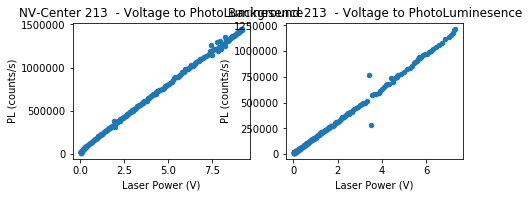

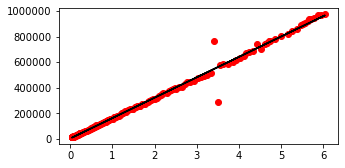

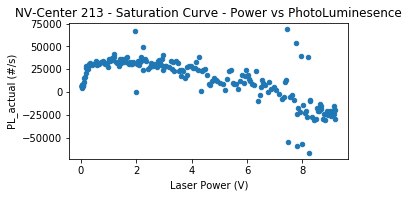

In [382]:
df = read_experiment_w_exp_volt('570', '6', '0V', background_picks, True)

Read all experiments

In [772]:
directory = 'SAT_CURVE'

# we'll be storing all experiments in a dictionary
dfs_wavelength = {}

# go through all files in folder
for filename in os.listdir(directory):
    f = os.path.join(directory, filename)

    # checking if it is a file
    if os.path.isfile(f):

        # take out the folder from the filename
        filename = f.split('/')[1]
        
        # obtain parameters to filename
        params = filename.split('_')

        if (len(params)<5):
            continue

        if (params[3] == 'bg'):
            continue

        # pick up parameters for experiment identification 
        wavelength = params[0]
        voltage = params[2]
        exp = params[4].split('.')[0]

        print (wavelength, voltage, exp)

        # read them all
        df = read_experiment_w_exp_volt(wavelength, exp, voltage, background_picks)

        # Convert voltage to mW, using our linear mapping
        df = map_to_mw(int(wavelength), df)

        # collect experiments in a neat dictionary
        # eg: Take the 0th experiment at 0V on 550nm, will be stored as: dfs_wavelength['550']['0V'][0]
        if wavelength not in dfs_wavelength:
            dfs_wavelength[wavelength] = {}

            if voltage not in dfs_wavelength[wavelength]:
                dfs_wavelength[wavelength][voltage] = []
                dfs_wavelength[wavelength][voltage].append(df)
            else:
                dfs_wavelength[wavelength][voltage].append(df)

        else:

            if voltage not in dfs_wavelength[wavelength]:
                dfs_wavelength[wavelength][voltage] = []
                dfs_wavelength[wavelength][voltage].append(df)
            else:
                dfs_wavelength[wavelength][voltage].append(df)

570 0V 6
['570', 'NV', '0V', 'fg', '6.txt']
['570', 'NV', '0V', 'bg', '5.txt']
565 0V 6
['565', 'NV', '0V', 'fg', '6.txt']
['565', 'NV', '0V', 'bg', '6.txt']
565 0V 7
['565', 'NV', '0V', 'fg', '7.txt']
['565', 'NV', '0V', 'bg', '6.txt']
570 0V 5
['570', 'NV', '0V', 'fg', '5.txt']
['570', 'NV', '0V', 'bg', '5.txt']
565 0V 5
['565', 'NV', '0V', 'fg', '5.txt']
['565', 'NV', '0V', 'bg', '6.txt']
565 0V 4
['565', 'NV', '0V', 'fg', '4.txt']
['565', 'NV', '0V', 'bg', '6.txt']
570 0V 4
['570', 'NV', '0V', 'fg', '4.txt']
['570', 'NV', '0V', 'bg', '5.txt']
570 0V 1
['570', 'NV', '0V', 'fg', '1.txt']
['570', 'NV', '0V', 'bg', '5.txt']
565 0V 1
['565', 'NV', '0V', 'fg', '1.txt']
['565', 'NV', '0V', 'bg', '6.txt']
565 0V 3
['565', 'NV', '0V', 'fg', '3.txt']
['565', 'NV', '0V', 'bg', '6.txt']
570 0V 3
['570', 'NV', '0V', 'fg', '3.txt']
['570', 'NV', '0V', 'bg', '5.txt']
570 0V 2
['570', 'NV', '0V', 'fg', '2.txt']
['570', 'NV', '0V', 'bg', '5.txt']
565 0V 2
['565', 'NV', '0V', 'fg', '2.txt']
['565', 

Clean data

In [773]:
dfs_wavelength_legit = dfs_wavelength.copy()

for w, voltages in dfs_wavelength.items(): # wavelength
	for v, experiments in voltages.items(): # voltage
		for ii, df in enumerate(experiments): # experiment

			print (f"Filtering {w}, {v}, {ii}")

			# df = df.loc[df['PL (counts/s)'] > 0,:]
			df = df.loc[df['PL_actual (#/s)'] > 0,:]
			df = df.loc[df['PL_actual (#/s)'] < 100000,:]
			df = df.loc[df['Laser Power (mW)'] < 80, :]

			dfs_wavelength_legit[w][v][ii] = df.reset_index(drop=True)

dfs_wavelength = dfs_wavelength_legit.copy()

Filtering 570, 0V, 0
Filtering 570, 0V, 1
Filtering 570, 0V, 2
Filtering 570, 0V, 3
Filtering 570, 0V, 4
Filtering 570, 0V, 5
Filtering 565, 0V, 0
Filtering 565, 0V, 1
Filtering 565, 0V, 2
Filtering 565, 0V, 3
Filtering 565, 0V, 4
Filtering 565, 0V, 5
Filtering 565, 0V, 6
Filtering 565, 0V, 7
Filtering 565, 0V, 8
Filtering 565, 0V, 9
Filtering 565, 0V, 10
Filtering 565, 0V, 11
Filtering 565, 0V, 12
Filtering 565, 0V, 13
Filtering 565, 0V, 14
Filtering 565, 0V, 15
Filtering 540, 0V, 0
Filtering 540, 0V, 1
Filtering 540, 0V, 2
Filtering 540, 0V, 3
Filtering 540, 0V, 4
Filtering 540, 0V, 5
Filtering 540, 0V, 6
Filtering 540, 0V, 7
Filtering 540, m10V, 0
Filtering 540, m10V, 1
Filtering 540, m10V, 2
Filtering 540, m10V, 3
Filtering 540, m10V, 4
Filtering 540, m10V, 5
Filtering 540, 10V, 0
Filtering 540, 10V, 1
Filtering 540, 10V, 2
Filtering 540, 10V, 3
Filtering 540, 10V, 4
Filtering 540, 10V, 5
Filtering 560, 0V, 0
Filtering 560, 0V, 1
Filtering 560, 0V, 2
Filtering 560, 0V, 3
Filtering 

Gather ensemble data across voltages for 540nm

In [401]:
nv_540_0v = dfs_wavelength['540']['0V'][0].append(dfs_wavelength['540']['0V'][1:])
nv_540_m10v = dfs_wavelength['540']['m10V'][0].append(dfs_wavelength['540']['m10V'][1:])
nv_540_10v = dfs_wavelength['540']['10V'][0].append(dfs_wavelength['540']['10V'][1:])

## toMw & Fitting 

In [513]:
def func_to_fit(x, b, c, d, e):
    return ((x**2) + b*x) / (c*(x**2) + d*x + e)

# km = (1 / 186.12E-9) 
# kn = (1 / 14.98E-9)

# from paper:
# --> Exploiting ionization dynamics in the nitrogen vacancy center for rapid, high-contrast spin, and charge state initialization
km = (1 / 186.12E-9)
kn = (1 / 14.98E-9)
kr = (1 / 14E-9)

fit_params = {
	'p0': [100000, 1e9, 1e6, 1e9], # inital values for c, ke, k8, kd
	'bounds': ((0, 0, 0, 0), (np.inf, np.inf, np.inf, np.inf)), # boundary
	'maxfev': 1000 # max iterations
}

def daria_fit(x, e, a, b, c):
	# d = km/kn  #? <-- Wrong Fixed RATIO (but works)
	d = kn/km  # <-- Correct RATIO
	
	return (e) / (1 + (1/(a*x)) + ((c*x)/(1+b*x)) + ((d)/(1+b*x) ) )

def adam_fit(x, e, a, b, c):	
	return (e) / (1 + (kr/(a*x)) + ((c*x)/(km+b*x)) + ((kn)/(km+b*x) ) )

k8 = 2.8021688781610127e-14 us^-1


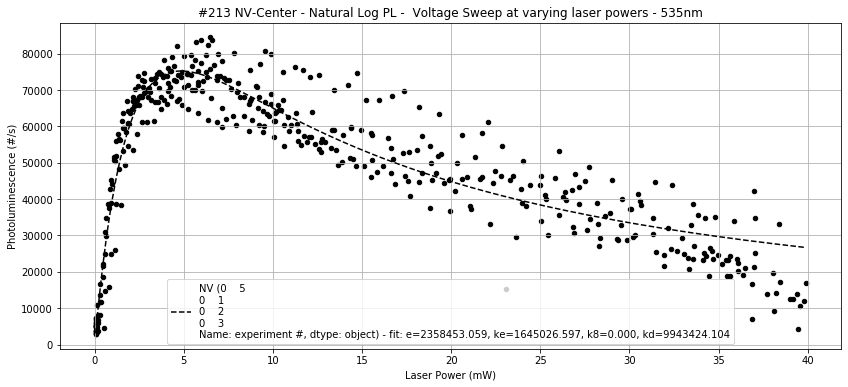

In [515]:
nv_540_0v = map_to_mw(540, nv_540_0v)
nv_540_m10v = map_to_mw(540, nv_540_m10v)
nv_540_10v = map_to_mw(540, nv_540_10v)

fig, (ax1) = plt.subplots(1,1, figsize=(14,6))  # 1 row, 2 columns
# perform_fit_ax(daria_fit, ax1, nv_540_0v, 'green', scatter=False)
a = perform_fit_ax(adam_fit, ax1, nv_540_m10v, fit_params, 'black', scatter=True, legend=True)

print (f"k8 = {a*10E-6} us^{-1}")

In [360]:
kn

66755674.23230975

In [359]:
km

5372877.713303246

### Ensemble Fit

k8 micro (s^-1): 0v = 0.14489100482607348, -10V = 2.6678888325486563e-16, 10V = 8.057286833177853e-14


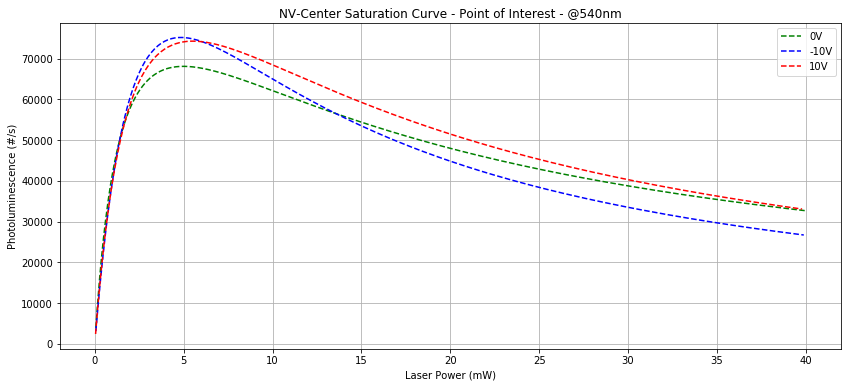

In [531]:
nv_540_0v = map_to_mw(540, nv_540_0v)
nv_540_m10v = map_to_mw(540, nv_540_m10v)
nv_540_10v = map_to_mw(540, nv_540_10v)

fig, (ax1) = plt.subplots(1,1, figsize=(14,6))  # 1 row, 2 columns
a = perform_fit_ax(adam_fit, ax1, nv_540_0v, fit_params, 'green', scatter=False, fit_label="0V")
b = perform_fit_ax(adam_fit, ax1, nv_540_m10v, fit_params, 'blue', scatter=False, fit_label="-10V")
c = perform_fit_ax(adam_fit, ax1, nv_540_10v, fit_params, 'red', scatter=False, fit_label="10V")

print (f"k8 micro (s^{-1}): 0v = {a*10E-6}, -10V = {b*10E-6}, 10V = {c*10E-6}")

ax1.set_title(f"NV-Center Saturation Curve - Point of Interest - @{540}nm")
ax1.legend()
ax1.grid(True)

plt.legend()

231.82163133946344

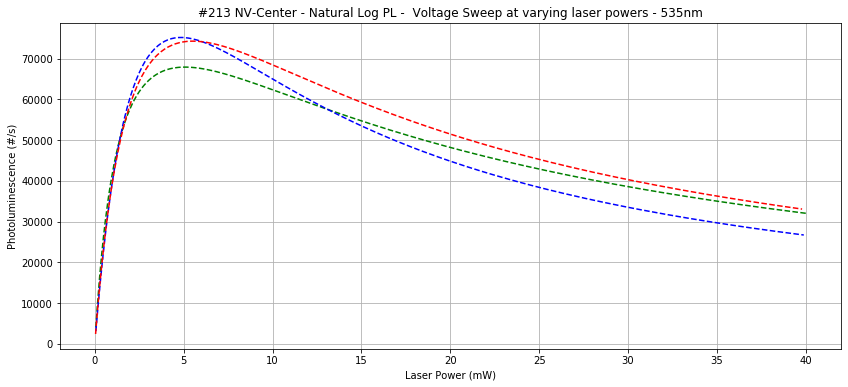

In [517]:
nv_540_0v = map_to_mw(540, nv_540_0v)
nv_540_m10v = map_to_mw(540, nv_540_m10v)
nv_540_10v = map_to_mw(540, nv_540_10v)

fig, (ax1) = plt.subplots(1,1, figsize=(14,6))  # 1 row, 2 columns
perform_fit_ax(func_to_fit, ax1, nv_540_0v, fit_params, 'green', scatter=False)
perform_fit_ax(func_to_fit, ax1, nv_540_m10v, fit_params, 'blue', scatter=False)
perform_fit_ax(func_to_fit, ax1, nv_540_10v, fit_params, 'red', scatter=False)

## Selection of favorable data

In [533]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D # <--- This is important for 3d plotting 
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

In [649]:
to_disregard = [
	['535', '0V', '6'],

	['540', 'm10V', '1'],

	['540', '10V', '6'],

	['540', '0V', '7'],
	['540', '0V', '6'],
	['540', '0V', '2'],

	['545', '0V', '5'],
	['545', '0V', '6'],
	
	['550', '0V', '1'],
	['550', '0V', '3'],
	['550', '0V', '5'],

	['555', '0V', '5'],

	
	['560', '0V', '3'],
	['560', '0V', '4'],
	['560', '0V', '1'],
	['560', '0V', '6'],

	['565', '0V', '16'],
	['565', '0V', '14'],
	['565', '0V', '2'],
	['565', '0V', '13'],
	['565', '0V', '15'],
	['565', '0V', '12'],
	['565', '0V', '11'],

	['565', '0V', '3'],
	['565', '0V', '9'],
	['565', '0V', '6'],
	['565', '0V', '5'],
	['565', '0V', '10'],
	# ['565', '0V', 13],

	['570', '0V', '6'],
	['570', '0V', '5'],
	['570', '0V', '4'],
	['570', '0V', '1'],

]

In [771]:
len(to_disregard)

32

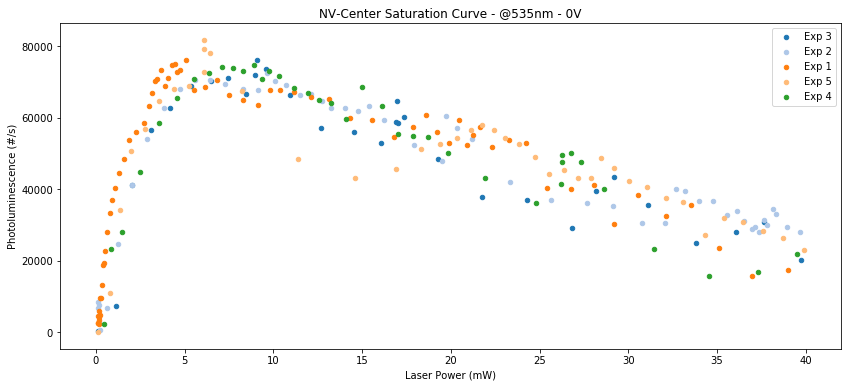

In [656]:
# this code is to go through each experiment (manually) then inspecting each experiment, and selecting a few discards, which are then added to the array above.

df_k8 = pd.DataFrame(columns=['wavelength', 'k8'])
fit_failed = [];

fit_params = {
	'p0': [100000, 1e6, 1e6, 1e6], # inital values for c, ke, k8, kd
	'bounds': ((0, 0, 1E5, 0), (np.inf, np.inf, np.inf, np.inf)), # boundary
	'maxfev': 2000 # max iterations
}

plasma = cm.get_cmap('tab20', 20)
colors = plasma(range(16))

wavelength='535'
voltage='0V'

experiments = dfs_wavelength[wavelength][voltage]

fig, (ax1) = plt.subplots(1,1, figsize=(14,6))  # 1 row, 2 columns

for ii, df in enumerate(experiments): # experiment

	w = df['Wavelength'][0]
	v = df['Voltage'][0]
	exp = df['experiment #'][0]

	if [str(w), v, exp] in to_disregard:
		continue

	df.plot.scatter(x='Laser Power (mW)', y='PL_actual (#/s)', ax=ax1, c=[colors[ii]], label=f'Exp {exp}')

ax1.set_title(f"NV-Center Saturation Curve - @{wavelength}nm - {voltage}")
ax1.set_xlabel("Laser Power (mW)")
ax1.set_ylabel("Photoluminescence (#/s)")
plt.legend()

df_k8.wavelength = df_k8.wavelength.astype(float)

Keep only meaningful data

In [774]:
dfs_wavelength_legit = {}

for w, voltages in dfs_wavelength.items(): # wavelength
	for v, experiments in voltages.items(): # voltage
		for ii, df in enumerate(experiments): # experiment

			print (f"Filtering {w}, {v}, {ii}")

			exp = df['experiment #'][0]

			if [w, v, exp] in to_disregard:
				continue

			dfs_wavelength_legit.setdefault(w, {})
			dfs_wavelength_legit[w].setdefault(v, [])

			dfs_wavelength_legit[w][v].append(df)

dfs_wavelength_legit

Filtering 570, 0V, 0
Filtering 570, 0V, 1
Filtering 570, 0V, 2
Filtering 570, 0V, 3
Filtering 570, 0V, 4
Filtering 570, 0V, 5
Filtering 565, 0V, 0
Filtering 565, 0V, 1
Filtering 565, 0V, 2
Filtering 565, 0V, 3
Filtering 565, 0V, 4
Filtering 565, 0V, 5
Filtering 565, 0V, 6
Filtering 565, 0V, 7
Filtering 565, 0V, 8
Filtering 565, 0V, 9
Filtering 565, 0V, 10
Filtering 565, 0V, 11
Filtering 565, 0V, 12
Filtering 565, 0V, 13
Filtering 565, 0V, 14
Filtering 565, 0V, 15
Filtering 540, 0V, 0
Filtering 540, 0V, 1
Filtering 540, 0V, 2
Filtering 540, 0V, 3
Filtering 540, 0V, 4
Filtering 540, 0V, 5
Filtering 540, 0V, 6
Filtering 540, 0V, 7
Filtering 540, m10V, 0
Filtering 540, m10V, 1
Filtering 540, m10V, 2
Filtering 540, m10V, 3
Filtering 540, m10V, 4
Filtering 540, m10V, 5
Filtering 540, 10V, 0
Filtering 540, 10V, 1
Filtering 540, 10V, 2
Filtering 540, 10V, 3
Filtering 540, 10V, 4
Filtering 540, 10V, 5
Filtering 560, 0V, 0
Filtering 560, 0V, 1
Filtering 560, 0V, 2
Filtering 560, 0V, 3
Filtering 

{'570': {'0V': [     Laser Power (V)  PL (counts/s)   PC (pA)  Wavelength Location Voltage  \
   0           0.045983   1.839738e+04 -0.728742         570       fg      0V   
   1           0.046775   1.839113e+04 -0.727005         570       fg      0V   
   2           0.046329   1.793746e+04 -0.725424         570       fg      0V   
   3           0.046280   1.829934e+04 -0.724555         570       fg      0V   
   4           0.044906   1.794494e+04 -0.724787         570       fg      0V   
   ..               ...            ...       ...         ...      ...     ...   
   178         8.981773   1.440617e+06 -0.699391         570       fg      0V   
   179         9.034260   1.452668e+06 -0.701180         570       fg      0V   
   180         9.134495   1.459234e+06 -0.703233         570       fg      0V   
   181         9.109897   1.473087e+06 -0.703426         570       fg      0V   
   182         9.090162   1.457154e+06 -0.703184         570       fg      0V   
   
        PL_

In [661]:
dfs_wavelength_legit

{'570': {}}

## Saturation Curves - See how things fit!

In [ ]:
km

5372877.713303246

In [ ]:
nv_550_0v = dfs_wavelength['550']['0V'][0].append(dfs_wavelength['550']['0V'][1:])

fitting 570nm at 0V (0)
fitting 570nm at 0V (1)
fitting 565nm at 0V (0)
fitting 565nm at 0V (1)
fitting 565nm at 0V (2)
fitting 565nm at 0V (3)
fitting 540nm at 0V (0)
fitting 540nm at 0V (1)
fitting 540nm at 0V (2)
fitting 540nm at 0V (3)
fitting 540nm at 0V (4)
fitting 540nm at m10V (0)
fitting 540nm at m10V (1)
fitting 540nm at m10V (2)
fitting 540nm at m10V (3)
fitting 540nm at m10V (4)
fitting 540nm at 10V (0)
fitting 540nm at 10V (1)
fitting 540nm at 10V (2)
fitting 540nm at 10V (3)
fitting 540nm at 10V (4)
fitting 560nm at 0V (0)
fitting 560nm at 0V (1)
fitting 555nm at 0V (0)
fitting 555nm at 0V (1)
fitting 555nm at 0V (2)
fitting 555nm at 0V (3)
fitting 555nm at 0V (4)
fitting 535nm at 0V (0)
fitting 535nm at 0V (1)
fitting 535nm at 0V (2)
fitting 535nm at 0V (3)
fitting 535nm at 0V (4)
fitting 550nm at 0V (0)
fitting 550nm at 0V (1)
fitting 550nm at 0V (2)
fitting 550nm at 0V (3)
fitting 545nm at 0V (0)
fitting 545nm at 0V (1)
fitting 545nm at 0V (2)
fitting 545nm at 0V (3)


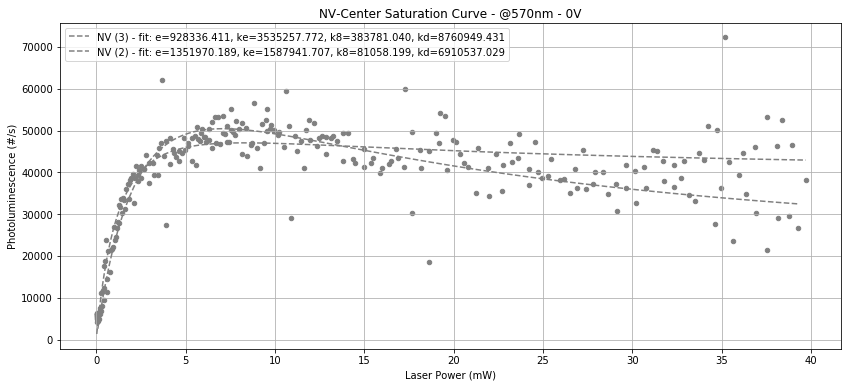

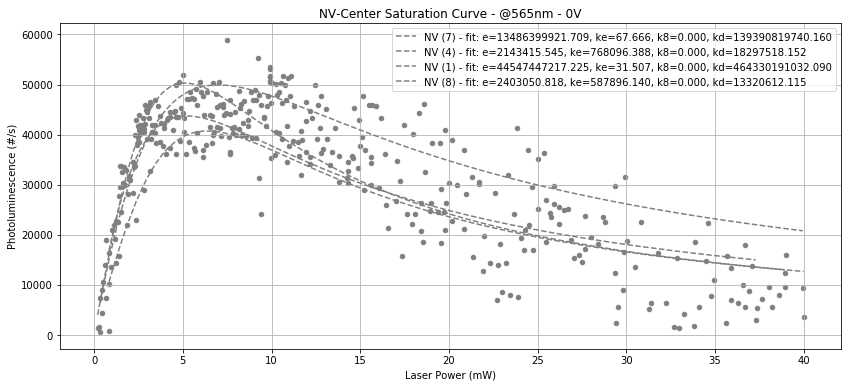

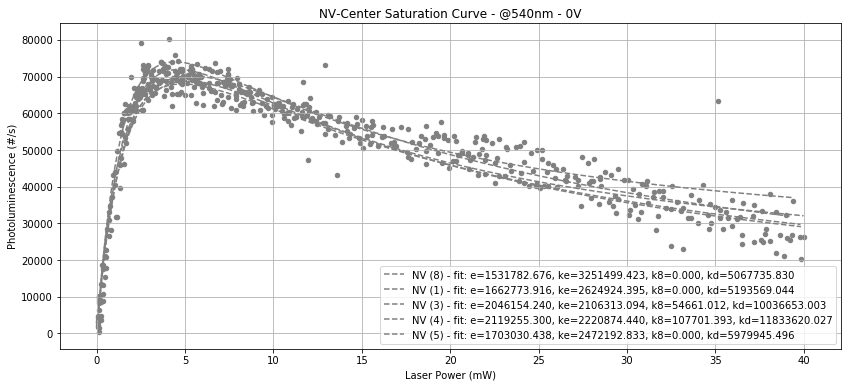

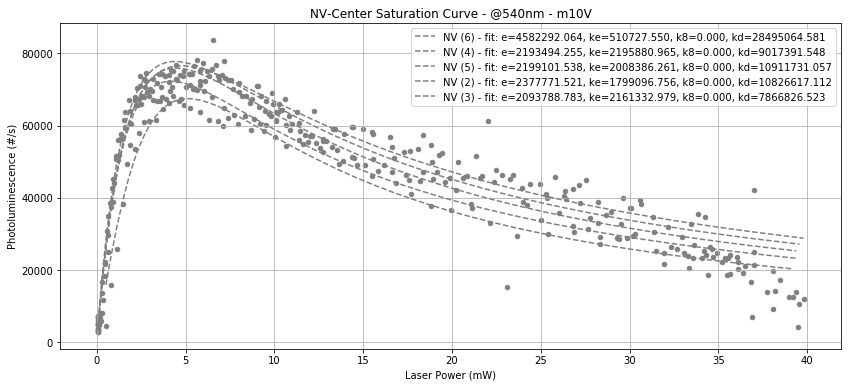

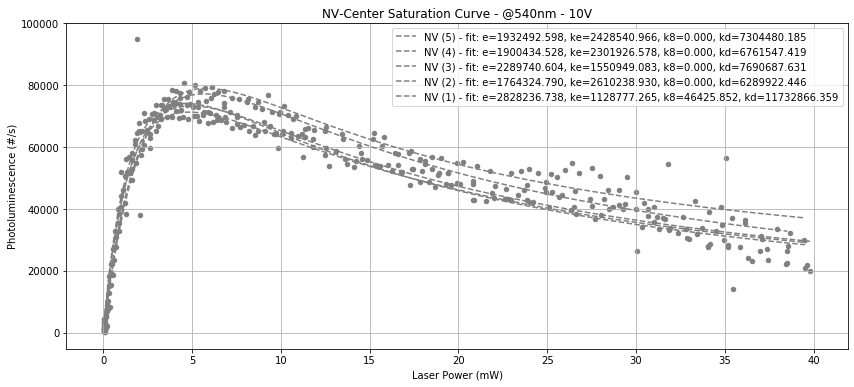

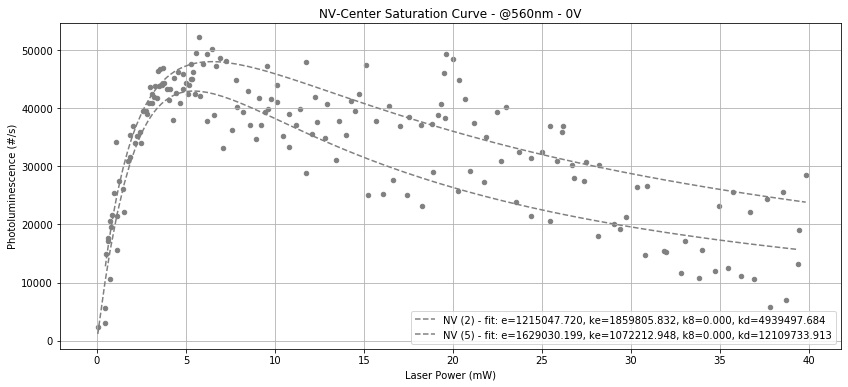

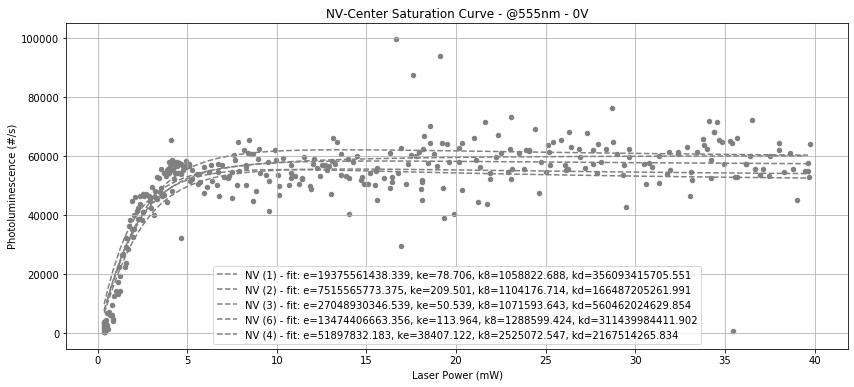

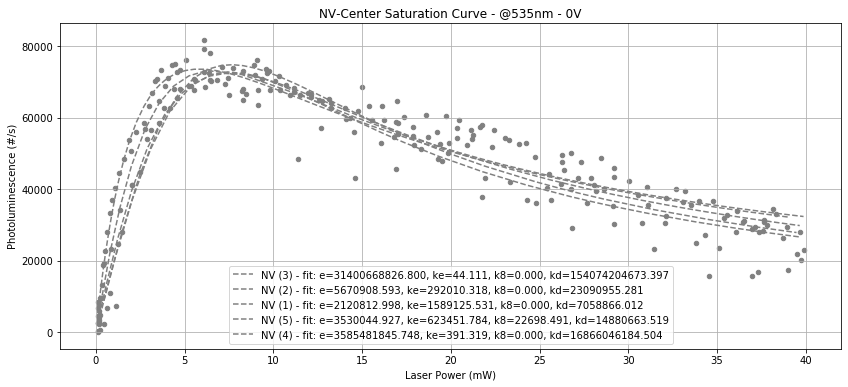

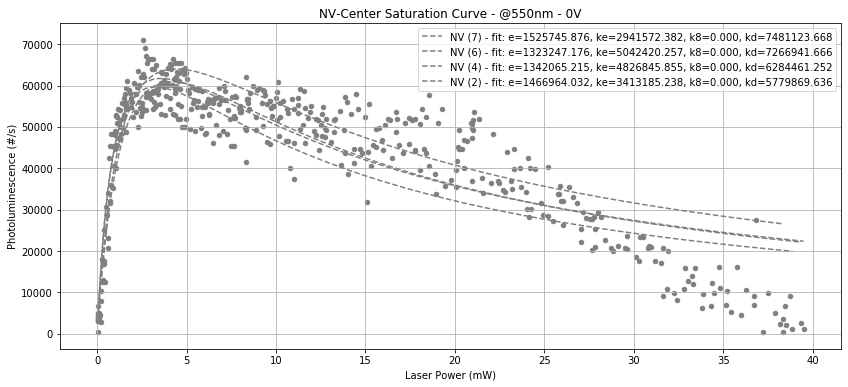

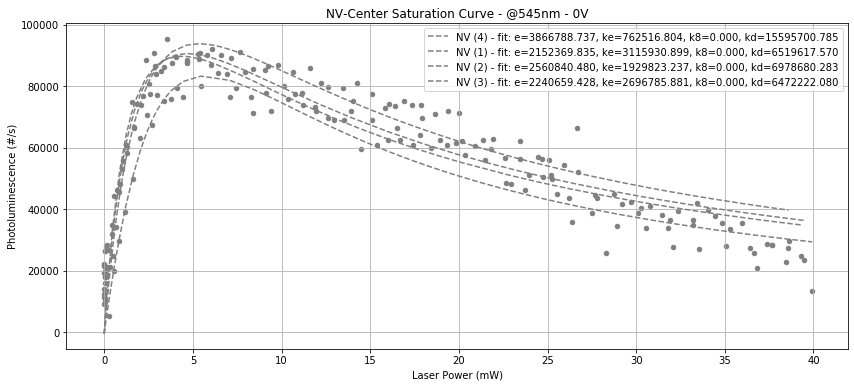

In [666]:
df_k8 = pd.DataFrame(columns=['wavelength', 'k8'])
fit_failed = [];

fit_params = {
	'p0': [100000, 1e6, 1e6, 1e6], # inital values for c, ke, k8, kd
	'bounds': ((0, 0, 0, 0), (np.inf, np.inf, np.inf, np.inf)), # boundary
	'maxfev': 2000 # max iterations
}

for w, voltages in dfs_wavelength_legit.items(): # wavelength
	for v, experiments in voltages.items(): # voltage

		fig, (ax1) = plt.subplots(1,1, figsize=(14,6))  # 1 row, 2 columns

		for ii, df in enumerate(experiments): # experiment
			print (f'fitting {w}nm at {v} ({ii})')
			try:
				k8 = perform_fit_ax(adam_fit, ax1, df, fit_params, 'grey', legend=True)
			
				df_k8 = df_k8.append({'wavelength': w, 'k8': k8}, ignore_index=True)
			except:
				fit_failed.append([w,v,ii])

		ax1.set_title(f"NV-Center Saturation Curve - @{w}nm - {v}")
		ax1.set_xlabel("Laser Power (mW)")
		ax1.set_ylabel("Photoluminescence (#/s)")

df_k8.wavelength = df_k8.wavelength.astype(float)

Plotting k8

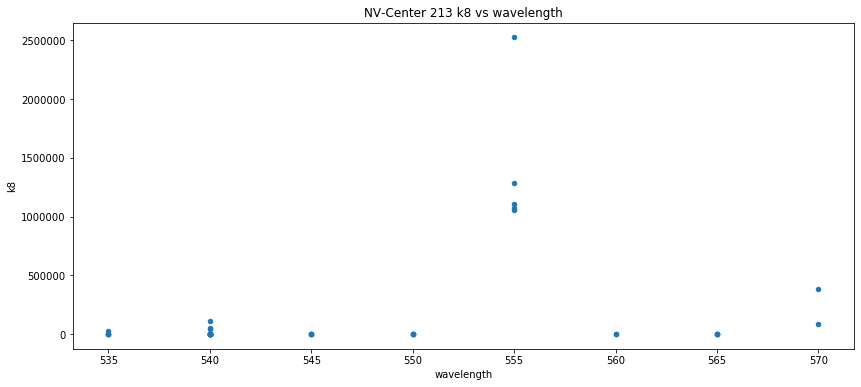

In [667]:
fig, (ax1) = plt.subplots(1,1, figsize=(14,6))  # 1 row, 2 columns
df_k8.plot.scatter(x='wavelength', y='k8', ax=ax1, legend=True, title=f"NV-Center {SAMPLE_NUMBER} k8 vs wavelength")

Clumb good fits together, and perform single fit through each wavelength seperately

In [746]:
df_bundle['535']

,Laser Power (V),PL (counts/s),PC (pA),Wavelength,Location,Voltage,PL_background,PL_actual (#/s),wavelength,experiment #,sample,Laser Power (mW)
0,0.029755,75061.480552,-0.454911,535,fg,0V,74840.064181,221.416371,535,3,213,0.121944
1,0.082409,90080.385196,-0.495650,535,fg,0V,82700.440850,7379.944346,535,3,213,1.119391
2,0.131128,131080.808081,-0.480150,535,fg,0V,89973.386704,41107.421377,535,3,213,2.047194
3,0.185935,154636.791324,-0.466307,535,fg,0V,98155.170882,56481.620442,535,3,213,3.090936
4,0.241919,169352.885780,-0.471407,535,fg,0V,106512.661812,62840.223968,535,3,213,4.157094
...,...,...,...,...,...,...,...,...,...,...,...,...
229,1.526697,338336.269329,-0.600508,535,fg,0V,298308.897930,40027.371399,535,4,213,28.624362
230,1.675579,343697.392732,-0.590096,535,fg,0V,320534.533196,23162.859536,535,4,213,31.459666
231,1.838084,360548.979874,-0.621288,535,fg,0V,344793.858426,15755.121448,535,4,213,34.554406
232,1.981021,383081.619537,-0.659847,535,fg,0V,366132.002916,16949.616621,535,4,213,37.276493


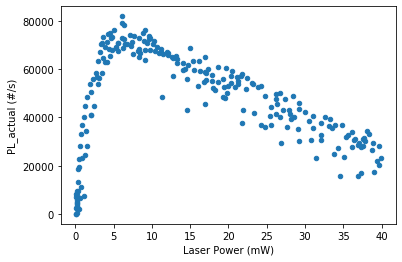

In [753]:
df_bundle['535'].plot.scatter(x='Laser Power (mW)', y='PL_actual (#/s)')

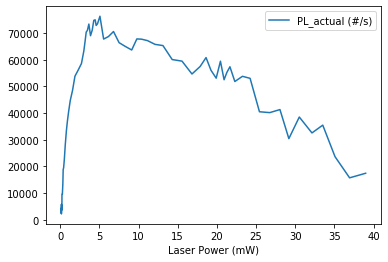

In [741]:
dfs_wavelength_legit['535']['0V'][2].plot(x='Laser Power (mW)', y='PL_actual (#/s)')

In [783]:
df_bundle = {}

for w, voltages in dfs_wavelength_legit.items(): # wavelength
	
	if w == '555':
		continue
	print (w)
	df_bundle[w] = pd.concat(dfs_wavelength_legit[w]['0V'], axis=0).reset_index(drop=True)
	# df_bundle[w] = df.reset_index(drop=True)

570
565
540
560
535
550
545


In [ ]:
df_amaze.plot

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

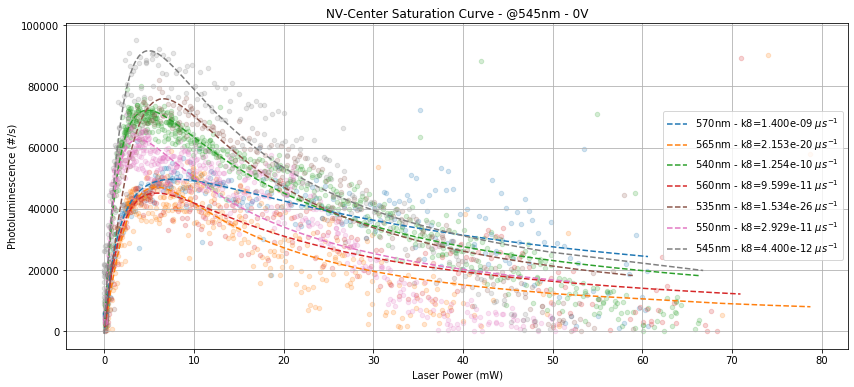

In [784]:
df_k8 = pd.DataFrame(columns=['wavelength', 'k8'])
fit_failed = [];

fit_params = {
	'p0': [100000, 1e6, 1e6, 1e6], # inital values for c, ke, k8, kd
	'bounds': ((0, 0, 0, 0), (np.inf, np.inf, np.inf, np.inf)), # boundary
	'maxfev': 2000 # max iterations
}

fig, (ax1) = plt.subplots(1,1, figsize=(14,6))  # 1 row, 2 columns

plasma = cm.get_cmap('tab10', 9)
colors = plasma(range(9))

i=0
for w, df_amaze in df_bundle.items(): # wavelength
	# print (f'fitting {w}nm at {v} ({ii})')

	k8 = perform_fit_ax(adam_fit, ax1, df_amaze.copy(), fit_params, colors[i], legend=True, scatter=True)
	df_k8 = df_k8.append({'wavelength': w, 'k8': k8}, ignore_index=True)

	ax1.set_title(f"NV-Center Saturation Curve - @{w}nm - {v}")
	ax1.set_xlabel("Laser Power (mW)")
	ax1.set_ylabel("Photoluminescence (#/s)")

	i=i+1

df_k8.wavelength = df_k8.wavelength.astype(float)

Selecting Good Experiments from bad ones.

Another approach to fitting might me to limit k8 to a specific number, like $10^6$, which would be $1 \mu s^{-1}$. If all curves fit well, we can claim that this k8 parameter fits the wavelength.

fitting 535nm at 0V (0)
fitting 535nm at 0V (1)
fitting 535nm at 0V (2)
fitting 535nm at 0V (3)
fitting 535nm at 0V (4)
fitting 535nm at 0V (5)


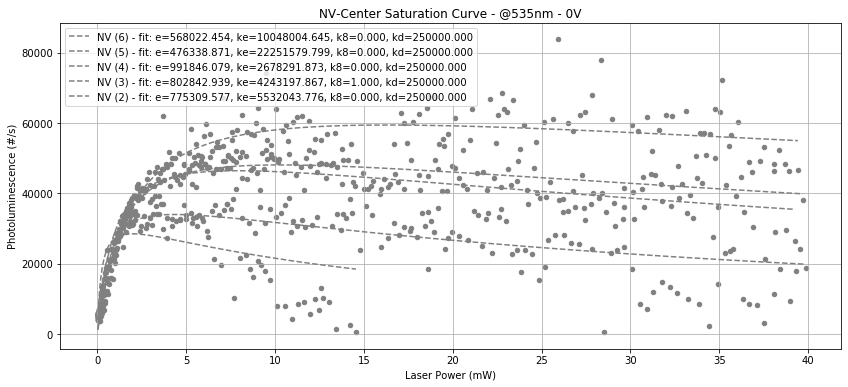

In [ ]:
df_k8 = pd.DataFrame(columns=['wavelength', 'k8'])
fit_failed = [];

def adam_fit_2(x, e, a, b, c):
	"""
	In this fit, kr, km and kn are fixed, taking values from literature

	a represents ke.
	kd is taken to be 0.237*ke, which is also taken from literature
	"""
	return (e) / (1 + (kr/(a*x)) + ((0.2*a*x)/(km+b*x)) + ((kn)/(km+b*x) ) )

fit_params = {
	'p0': [100000, 1e6, 0, 0.25*1e6], # inital values for c, ke, k8, kd
	'bounds': ((0, 0, 0, 0), (np.inf, np.inf, 1, np.inf)), # boundary, 3rth param bounds k8
	'maxfev': 2000, # max iterations,
}

experiments = dfs_wavelength['570']
for v, experiments in experiments.items(): # voltage

	fig, (ax1) = plt.subplots(1,1, figsize=(14,6))  # 1 row, 2 columns

	for ii, df in enumerate(experiments): # experiment
		print (f'fitting {535}nm at {v} ({ii})')
		try:
			k8 = perform_fit_ax(adam_fit_2, ax1, df, fit_params, 'grey', legend=True)
		
			df_k8 = df_k8.append({'wavelength': w, 'k8': k8}, ignore_index=True)
		except:
			fit_failed.append([w,v,ii])

	ax1.set_title(f"NV-Center Saturation Curve - @{535}nm - {v}")
	ax1.set_xlabel("Laser Power (mW)")
	ax1.set_ylabel("Photoluminescence (#/s)")

df_k8.wavelength = df_k8.wavelength.astype(float)

fitting 535nm at 0V (0)
fitting 535nm at 0V (1)
fitting 535nm at 0V (2)
fitting 535nm at 0V (3)
fitting 535nm at 0V (4)
fitting 535nm at 0V (5)


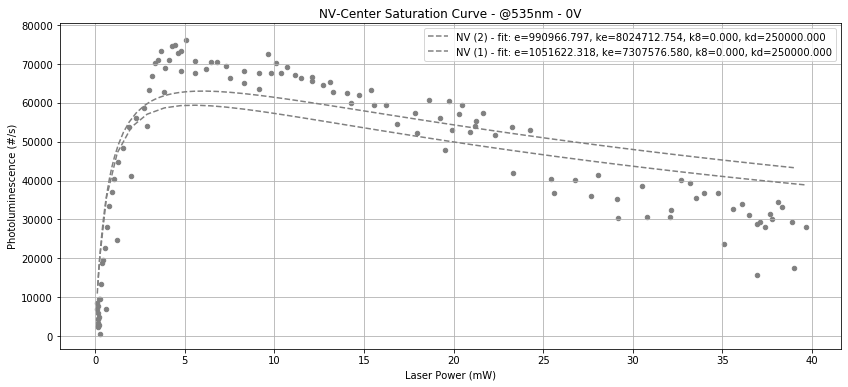

In [ ]:
df_k8 = pd.DataFrame(columns=['wavelength', 'k8'])
fit_failed = [];

def adam_fit(x, e, a, b, c):	
	"""
	In this fit, kr, km and kn are fixed, taking values from literature

	a = ke
	b = k8
	c = kd
	
	kd (c) is taken to be 0.237*ke, which is also taken from literature
	"""
	return (e) / (1 + (kr/(a*x)) + ((c*x)/(km+b*x)) + ((kn)/(km+b*x) ) )

def adam_fit_2(x, e, a, b, c):
	"""
	In this fit, kr, km and kn are fixed, taking values from literature

	a = ke
	b = k8
	
	kd (c) is taken to be 0.237*ke, which is also taken from literature
	"""
	return (e) / (1 + (kr/(a*x)) + ((0.2*a*x)/(km+b*x)) + ((kn)/(km+b*x) ) )

fit_params = {
	'p0': [100000, 1e9, 1e3, 0.25*1e6], # inital values for c, ke, k8, kd
	'bounds': ((0, 0, 0, 0), (np.inf, np.inf, np.inf, np.inf)), # boundary, 3rth param bounds k8
	'maxfev': 2000, # max iterations,
}

experiments = dfs_wavelength['535']['0V']

fig, (ax1) = plt.subplots(1,1, figsize=(14,6))  # 1 row, 2 columns

for ii, df in enumerate(experiments): # experiment
	print (f'fitting {535}nm at {v} ({ii})')
	try:
		k8 = perform_fit_ax(adam_fit_2, ax1, df, fit_params, 'grey', legend=True)
	
		df_k8 = df_k8.append({'wavelength': w, 'k8': k8}, ignore_index=True)
	except:
		fit_failed.append([w,v,ii])

ax1.set_title(f"NV-Center Saturation Curve - @{535}nm - {v}")
ax1.set_xlabel("Laser Power (mW)")
ax1.set_ylabel("Photoluminescence (#/s)")

df_k8.wavelength = df_k8.wavelength.astype(float)